### Treinamento Final do Modelo de Fraude

Treinamento do modelo final de fraude com os melhores hiperparâmetros, pipeline  e threshold escolhido.

---

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (108090, 30)
X_test: (36030, 30)
y_train: (108090,)
y_test: (36030,)


### Pipeline final

---


Pipeline definido com base nos melhores resultados do Notebook 05 e 06.


Optei por um modelo linear com regularização e balanceamento de classes, priorizando estabilidade, interpretabilidade e capacidade de generalização — características fundamentais em sistemas antifraude.

In [3]:
pipeline_final = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('model', LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    ))
])

In [4]:
pipeline_final.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

### Avaliação inicial no conjunto de teste

---



Avaliação inicial, pois a validação robusta será feita fora da amostra no próximo notebook.

In [5]:
y_prob = pipeline_final.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.9780


### MATRIZ DE CONFUSÃO

---

A matriz de confusão com threshold padrão é apenas exploratória. Em fraude, o threshold ótimo depende do custo de negócio, e será definido no próximo notebook

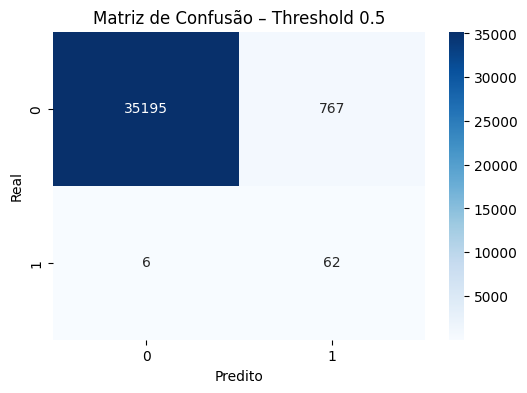

In [6]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão – Threshold 0.5')
plt.show()

O modelo apresenta capacidade consistente de identificar fraudes, com recall significativamente superior ao baseline, mantendo precisão controlada. A escolha final do threshold será guiada pelo impacto de negócio

---



In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     35962
         1.0       0.07      0.91      0.14        68

    accuracy                           0.98     36030
   macro avg       0.54      0.95      0.56     36030
weighted avg       1.00      0.98      0.99     36030



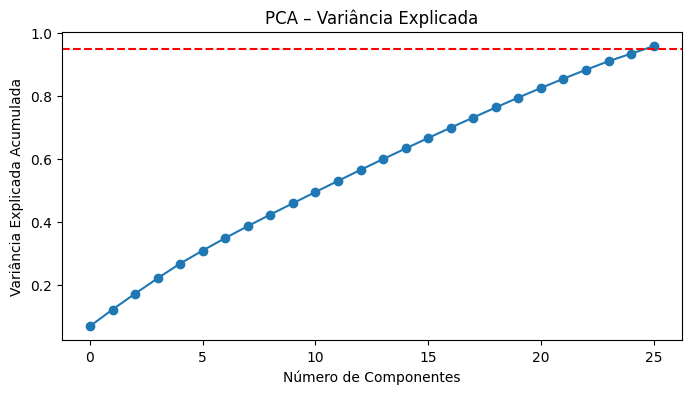

In [8]:
pca = pipeline_final.named_steps['pca']
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.axhline(0.95, color='red', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA – Variância Explicada')
plt.show()

A maior parte da informação original está concentrada em um número reduzido de componentes, o que indica redundância entre variáveis por isso foi utilizado o PCA para estabilização do modelo.

In [9]:
import joblib

joblib.dump(pipeline_final, "fraud_model_pipeline.joblib")

print("Pipeline final salvo com sucesso: fraud_model_pipeline.joblib")

Pipeline final salvo com sucesso: fraud_model_pipeline.joblib
